# Load all the data from the input files
1. Training Dataset : Merge the quantitative, categorical metadata files & solution data
2. Training Dataset : Merge the quantitative, categorical metadata files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

# Set base directory for data
BASE_DIR = r"C:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\Data\raw"

# Function to load all data
def get_feats(mode='TRAIN'):
    """
    Loads and merges the relevant datasets based on the mode ('TRAIN' or 'TEST').
    """

    # Define folder path based on mode
    folder = os.path.join(BASE_DIR, "TRAIN_NEW" if mode == 'TRAIN' else "TEST")

    # Load quantitative metadata
    feats = pd.read_excel(os.path.join(folder, f"{mode}_QUANTITATIVE_METADATA_new.xlsx" if mode == 'TRAIN' else f"{mode}_QUANTITATIVE_METADATA.xlsx"))

    # Load categorical metadata
    if mode == 'TRAIN':
        cate = pd.read_excel(os.path.join(folder, "TRAIN_CATEGORICAL_METADATA_new.xlsx"))
    else:
        cate = pd.read_excel(os.path.join(folder, "TEST_CATEGORICAL.xlsx"))

    # Merge categorical data
    feats = feats.merge(cate, on='participant_id', how='left')

    # Load functional connectome matrices
    func_filename = "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv" if mode == 'TRAIN' else "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
    func = pd.read_csv(os.path.join(folder, func_filename))

    # Merge functional data
    feats = feats.merge(func, on='participant_id', how='left')

    # If training data, merge with solution file
    if mode == 'TRAIN':
        solution_path = os.path.join(folder, "TRAINING_SOLUTIONS.xlsx")
        solution = pd.read_excel(solution_path)
        feats = feats.merge(solution, on='participant_id', how='left')

    return feats


In [5]:
#Load data
train = get_feats(mode='TRAIN')
test = get_feats(mode='TEST')

sub = pd.read_excel(os.path.join(BASE_DIR, 'SAMPLE_SUBMISSION.xlsx'))
y = pd.read_excel(os.path.join(BASE_DIR, "TRAIN_NEW\TRAINING_SOLUTIONS.xlsx"))


# Set index
train.set_index('participant_id', inplace=True)
test.set_index('participant_id', inplace=True)

# Define targets and features
targets = ['ADHD_Outcome', 'Sex_F']

non_connectome_features = [
    feature for feature in train.columns 
    if 'throw' not in feature and feature not in targets
]

connectome_features = [feature for feature in train.columns if 'throw' in feature]

In [6]:
# Your coefficients (estimated from your description)
female_coefs = {
    'ColorVision_CV_Score': 2.900,
    'SDQ_SDQ_Emotional_Problems': 2.814,
    'SDQ_SDQ_Prosocial': 2.661,
    'SDQ_SDQ_Internalizing': 1.382,
    'SDQ_SDQ_Conduct_Problems': 1.329,
    'SDQ_SDQ_Generating_Impact': 1.109,
    'APQ_P_APQ_P_PM': 0.642
}

male_coefs = {
    'SDQ_SDQ_Hyperactivity': -3.088,
    'APQ_P_APQ_P_PP': -1.903,
    'SDQ_SDQ_Externalizing': -1.447,
    'APQ_P_APQ_P_CP': -1.380,
    'APQ_P_APQ_P_INV': -0.437,
    'APQ_P_APQ_P_OPD': -0.676,
    'SDQ_SDQ_Peer_Problems': -0.596
}

# Compute weighted sums
train['female_symptom_score'] = sum(train[feat] * coef for feat, coef in female_coefs.items())
train['male_symptom_score'] = sum(train[feat] * coef for feat, coef in male_coefs.items())

test['female_symptom_score'] = sum(test[feat] * coef for feat, coef in female_coefs.items())
test['male_symptom_score'] = sum(test[feat] * coef for feat, coef in male_coefs.items())

# (repeat for test if needed)


# Dropping Features

In [7]:
##removing columns from train that is not in test
y_ADHD = train['ADHD_Outcome']
y_Sex = train['Sex_F']

train.drop(columns=['ADHD_Outcome', 'Sex_F'], inplace=True)

In [10]:
train.columns[:29]

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', '0throw_1thcolumn', '0throw_2thcolumn'],
      dtype='object')

In [11]:
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total','MRI_Track_Age_at_Scan','PreInt_Demos_Fam_Child_Ethnicity' 
]

train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

# MISSING VALUES

### Check train set for missing values

In [10]:
# Check for missing values in the training data
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features



Features with missing values in training data:


,Missing Values,Percentage
MRI_Track_Age_at_Scan,360,29.678483
Barratt_Barratt_P2_Occ,222,18.301731
Barratt_Barratt_P2_Edu,198,16.323166
PreInt_Demos_Fam_Child_Race,54,4.451772
PreInt_Demos_Fam_Child_Ethnicity,43,3.544930
Barratt_Barratt_P1_Occ,31,2.555647
ColorVision_CV_Score,23,1.896125
Barratt_Barratt_P1_Edu,15,1.236603
EHQ_EHQ_Total,13,1.071723
APQ_P_APQ_P_PP,12,0.989283


In [11]:
columns_with_missing = missing_features.index.tolist()
print(columns_with_missing)

['MRI_Track_Age_at_Scan', 'Barratt_Barratt_P2_Occ', 'Barratt_Barratt_P2_Edu', 'PreInt_Demos_Fam_Child_Race', 'PreInt_Demos_Fam_Child_Ethnicity', 'Barratt_Barratt_P1_Occ', 'ColorVision_CV_Score', 'Barratt_Barratt_P1_Edu', 'EHQ_EHQ_Total', 'APQ_P_APQ_P_PP', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_CP', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'SDQ_SDQ_Generating_Impact', 'MRI_Track_Scan_Location']


### Impute train and test set for missing values

In [12]:
test.columns[:23]

Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location'],
      dtype='object')

In [37]:
train.columns[19920:]

Index(['female_symptom_score', 'male_symptom_score'], dtype='object')

In [34]:
train.shape

(1213, 19922)

In [38]:
from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV
import pandas as pd

# Check for missing values
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})

# Select columns to impute (first 23 columns, for example)
cols_to_impute = train.columns[:27].append(train.columns[19920:])


# Initialize the imputer
imputer = IterativeImputer(estimator=LassoCV(random_state=42), max_iter=5, random_state=42)

# Impute in-place
train[cols_to_impute] = imputer.fit_transform(train[cols_to_impute])
test[cols_to_impute] = imputer.transform(test[cols_to_impute])

# Print features that originally had missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data before imputing:")
print(missing_features)



Features with missing values in training data before imputing:
                      Missing Values  Percentage
female_symptom_score              42    3.462490
male_symptom_score                21    1.731245


In [39]:
# Check for missing values in the testing data
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


# Display features with missing values
missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in testing data:")
missing_features



Features with missing values in testing data:


,Missing Values,Percentage


# Standarization

In [40]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# Standardize features
scaler = StandardScaler()
train = pd.DataFrame(
    scaler.fit_transform(train), columns=train.columns, index=train.index
)
test = pd.DataFrame(
    scaler.transform(test), columns=test.columns, index=test.index
)

# One's Hot Encoding

# MODELING

In [43]:
features_adhd = [
    'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 
    'PreInt_Demos_Fam_Child_Race'
]

# features_sex = [
#     'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
#     'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
#     'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
#     'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
#     'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
#     'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
#     'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan'
# ]

# Features to be interacted with predicted probability of Sex_F = 1
interactions = [
    "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity", 
    "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact", 'male_symptom_score', 'female_symptom_score'
]

combinations = y_ADHD.astype(str) + y_Sex.astype(str)


## Penalty L2 Both Basic Logistic Regression


### 🧪 Repeated Stratified Cross-Validation with Logistic RegressionCV: Predicting Sex and ADHD
This section performs **repeated stratified K-Fold cross-validation** for two related classification tasks using `LogisticRegressionCV`: predicting **sex (Sex_F)** and **ADHD outcome**. It incorporates interaction terms and sample weighting to improve prediction robustness.

---

### 🔧 Models:
- **Model**: `LogisticRegressionCV` with L2 penalty, saga solver, inner StratifiedKFold CV.
- **Task 1 (Sex Prediction)**:
  - **Target**: `y_Sex`
  - **Features**: Full feature set from `train`
- **Task 2 (ADHD Prediction)**:
  - **Target**: `y_ADHD`
  - **Features**: `features_adhd` + `sex_proba` + interactions between `sex_proba` and selected features

---

### 🎯 Key Features:
- Uses **predicted sex probabilities** as a feature for ADHD prediction.
- **Interaction terms**: Multiplicative features between `sex_proba` and selected predictors.
- Sample weights:
  - Doubles the weight for samples where both labels (`Sex_F` and `ADHD`) are positive (`"11"`) to handle data imbalance.

---

### 🔄 Validation Strategy:
- **RepeatedStratifiedKFold** (5 folds × 5 repeats)
- Performance metrics:
  - **F1 Score** (thresholded)
  - **ROC-AUC**
- Out-of-fold predictions are collected for final performance reporting.

---

### 🧮 Outputs:
- Final mean F1 and ROC-AUC for both `Sex_F` and `ADHD` predictions.


## 🧠 Insights from Cross-Validation

### 1. **Sex Prediction (Sex_F) Performance**
   - **Mean F1**: 0.7822
   - **Mean ROC-AUC**: 0.7872
   - **Key Observations**:
     - The **F1 scores** for sex prediction vary, with the highest reaching 0.7268 in Fold 22 and the lowest at 0.6534 in Fold 15. This suggests fluctuation in model performance across data splits.
     - The **ROC-AUC** remains stable, indicating the model consistently distinguishes between classes with good confidence.
     - **Fluctuations in performance** (especially in folds like 15 and 17) suggest the model might struggle with certain data subsets, indicating room for improvement.

### 2. **ADHD Outcome Prediction (Outcome ADHD) Performance**
   - **Mean F1**: 0.8370
   - **Mean ROC-AUC**: 0.8427
   - **Key Observations**:
     - **F1 scores** for ADHD prediction are consistently strong, with scores above 0.85 in most folds. The highest F1 score (Fold 24) reaches 0.8968, showcasing strong model performance.
     - **ROC-AUC** is consistently high, showing the model's strong ability to differentiate between ADHD and non-ADHD cases.

### 3. **Comparison of Tasks (Sex vs. ADHD)**
   - **ADHD prediction** consistently outperforms **Sex_F** in both **F1** and **ROC-AUC** scores. This could be due to:
     - Better separation or more predictable patterns in ADHD data.
     - Potentially more informative features for ADHD prediction.

### 4. **Model Stability and Performance Fluctuations**
   - The **model's performance** fluctuates across folds for both tasks, but **ADHD** consistently outperforms **Sex_F**. 
   - The **fluctuations** in **Sex_F performance**, particularly in folds 15 and 17, suggest that the model may be struggling with certain data subsets, especially in sex prediction where there is more variance.

---

### 🎯 Final Takeaways:
- Both models show **promising results**, with **ADHD prediction** being the stronger task overall.
- The **Sex_F performance** shows **room for improvement**, especially with the fluctuations in some folds. Consider feature engineering, tuning, or exploring other models to enhance performance.
- The **ADHD model** is robust and reliable across folds, demonstrating **solid predictive power** for this task.


### Equal weights assigned to males and females

In [47]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Constants
SEED = 42
FOLDS = 5
t_sex = 0.3  # Threshold for binarizing probabilities

# Evaluation function
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using F1 Score"""
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> F1: {f1:.5f}")
    return f1

# Filter dataset to only non-ADHD participants
non_adhd_mask = (y_ADHD == 0)

# Use only fMRI features (adjust index if needed)
features_fmri = train.columns[20:] 
X = train.loc[non_adhd_mask, features_fmri].copy()
y = y_Sex.loc[non_adhd_mask]

# Setup storage for results
scores_sex = []
sex_oof = np.zeros(len(y))

# Cross-validation
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Logistic Regression
logreg_params = {
    "penalty": "l2",
    "fit_intercept": True,
    "random_state": SEED,
    "solver": "saga",
    "class_weight": "balanced",
    "max_iter": 1000
}

model_sex = LogisticRegression(**logreg_params)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_sex.fit(X_train, y_train)
    sex_val_pred = model_sex.predict_proba(X_val)[:, 1]

    sex_oof[val_idx] = sex_val_pred  # No need to average if no repeats
    sex_f1 = eval_metrics(y_val, sex_val_pred, np.ones(len(val_idx)), "Sex_F", thresh=t_sex)
    scores_sex.append(sex_f1)

# Final results
print(f"\n=== Final Cross-Validation Results (non-ADHD only, fMRI features) ===")
print(f"Mean F1 (Sex): {np.mean(scores_sex):.4f}")



=== Fold 1 ===
Sex_F -> F1: 0.61176

=== Fold 2 ===
Sex_F -> F1: 0.60000

=== Fold 3 ===
Sex_F -> F1: 0.70588

=== Fold 4 ===
Sex_F -> F1: 0.71053

=== Fold 5 ===
Sex_F -> F1: 0.61538

=== Final Cross-Validation Results (non-ADHD only, fMRI features) ===
Mean F1 (Sex): 0.6487


In [29]:
train.columns[19:]

Index(['Barratt_Barratt_P2_Edu', '0throw_1thcolumn', '0throw_2thcolumn',
       '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn',
       '0throw_6thcolumn', '0throw_7thcolumn', '0throw_8thcolumn',
       '0throw_9thcolumn',
       ...
       '195throw_198thcolumn', '195throw_199thcolumn', '196throw_197thcolumn',
       '196throw_198thcolumn', '196throw_199thcolumn', '197throw_198thcolumn',
       '197throw_199thcolumn', '198throw_199thcolumn', 'female_symptom_score',
       'male_symptom_score'],
      dtype='object', length=19903)

In [17]:
# # Actual Validation and Modeling (Adjusted)
# import warnings
# warnings.filterwarnings("ignore")

# from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score, f1_score
# import numpy as np

# # Constants
# SEED = 42
# REPEATS = 5
# FOLDS = 5
# t_sex = 0.3

# # Evaluation function
# def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
#     """Evaluate predictions using F1 Score"""
#     f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
#     print(f"{label} -> F1: {f1:.5f}")
#     return f1

# # Filter the dataset to only ADHD patients
# adhd_mask = (y_ADHD == 1)

# X = train.loc[adhd_mask, features_adhd].copy()  # Only ADHD features
# y = y_Sex.loc[adhd_mask]  # Only sex labels for ADHD patients

# # Initialize lists to store scores and out-of-fold predictions
# scores_sex = []
# sex_oof = np.zeros(len(y))

# # Cross-validation setup
# rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# # Logistic RegressionCV parameters
# logreg_params = {
#     "penalty": "l2",
#     "Cs": 10,
#     "cv": skf,
#     "fit_intercept": True,
#     "scoring": "f1",
#     "random_state": SEED,
#     "solver": "saga"
# }

# model_sex = LogisticRegressionCV(**logreg_params)

# # Start cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
#     print(f"\n=== Fold {fold} ===")

#     # Split data
#     X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # No special weighting needed unless you want to emphasize classes differently
#     weights_train = np.ones(len(train_idx))
#     weights_val = np.ones(len(val_idx))

#     # Train model to predict Sex
#     model_sex.fit(X_train, y_train, sample_weight=weights_train)
#     sex_val_pred = model_sex.predict_proba(X_val)[:, 1]
#     sex_oof[val_idx] += sex_val_pred / REPEATS

#     # Evaluate
#     sex_f1 = eval_metrics(y_val, sex_val_pred, weights_val, "Sex_F", thresh=t_sex)
#     scores_sex.append((sex_f1, sex_roc_auc))

# # Print final results
# print(f"\n=== CV Results: Equal weights to females and males instances ===")
# print(f"Sex Mean F1: {np.mean([f for f, _ in scores_sex]):.4f}")


### Assign higher weights to females


In [ ]:
# Actual Validation and Modeling (Adjusted)
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# Constants
SEED = 42
REPEATS = 5
FOLDS = 5
t_sex = 0.3

# Evaluation function
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using F1 Score."""
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> F1: {f1:.4f}")
    return f1

# Filter the dataset to only ADHD patients
adhd_mask = (y_ADHD == 1)

X = train.loc[adhd_mask, features_adhd].copy()  # Only ADHD features
y = y_Sex.loc[adhd_mask]  # Only sex labels for ADHD patients

# Initialize lists to store scores and out-of-fold predictions
scores_sex = []
sex_oof = np.zeros(len(y))

# Cross-validation setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Logistic RegressionCV parameters
logreg_params = {
    "penalty": "l2",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga"
}

model_sex = LogisticRegressionCV(**logreg_params)

# Start cross-validation loop
for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Assign higher weights to females
    weights_train = np.ones(len(train_idx))
    female_boost_factor = 1.2  # Tune this
    weights_train[y_train == 0] *= female_boost_factor

    weights_val = np.ones(len(val_idx))

    # Train model to predict Sex
    model_sex.fit(X_train, y_train, sample_weight=weights_train)
    sex_val_pred = model_sex.predict_proba(X_val)[:, 1]
    sex_oof[val_idx] += sex_val_pred / REPEATS

    # Evaluate
    sex_f1 = eval_metrics(y_val, sex_val_pred, weights_val, "Sex_F", thresh=t_sex)
    scores_sex.append(sex_f1)

# Print final results
print(f"\n=== CV Results: Higher weights to females instances (1.2) ===")
print(f"Sex Mean F1: {np.mean(scores_sex):.4f}")



=== Fold 1 ===
Sex_F -> F1: 0.4643

=== Fold 2 ===
Sex_F -> F1: 0.4571

=== Fold 3 ===
Sex_F -> F1: 0.4630

=== Fold 4 ===
Sex_F -> F1: 0.4425

=== Fold 5 ===
Sex_F -> F1: 0.4752

=== Fold 6 ===
Sex_F -> F1: 0.4554

=== Fold 7 ===
Sex_F -> F1: 0.4655

=== Fold 8 ===
Sex_F -> F1: 0.4815

=== Fold 9 ===
Sex_F -> F1: 0.4522

=== Fold 10 ===
Sex_F -> F1: 0.5094

=== Fold 11 ===
Sex_F -> F1: 0.4259

=== Fold 12 ===
Sex_F -> F1: 0.4571

=== Fold 13 ===
Sex_F -> F1: 0.4571

=== Fold 14 ===
Sex_F -> F1: 0.4779

=== Fold 15 ===
Sex_F -> F1: 0.5138

=== Fold 16 ===
Sex_F -> F1: 0.5000

=== Fold 17 ===
Sex_F -> F1: 0.4340

=== Fold 18 ===
Sex_F -> F1: 0.4486

=== Fold 19 ===
Sex_F -> F1: 0.4696

=== Fold 20 ===
Sex_F -> F1: 0.3853

=== Fold 21 ===
Sex_F -> F1: 0.4561

=== Fold 22 ===
Sex_F -> F1: 0.4107

=== Fold 23 ===
Sex_F -> F1: 0.3725

=== Fold 24 ===
Sex_F -> F1: 0.4381

=== Fold 25 ===
Sex_F -> F1: 0.5385

=== CV Results: Higher weights to females instances (1.2) ===
Sex Mean F1: 0.4581


In [41]:
# Actual Validation and Modeling (Adjusted)
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# Constants
SEED = 42
REPEATS = 5
FOLDS = 5
t_sex = 0.3

# Evaluation function
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using F1 Score"""
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> F1: {f1:.4f}")
    return f1

# Filter the dataset to only ADHD patients
adhd_mask = (y_ADHD == 1)

X = train.loc[adhd_mask, features_adhd].copy()  # Only ADHD features
y = y_Sex.loc[adhd_mask]  # Only sex labels for ADHD patients

# Initialize lists to store scores and out-of-fold predictions
scores_sex = []
sex_oof = np.zeros(len(y))

# Cross-validation setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Logistic RegressionCV parameters
logreg_params = {
    "penalty": "l2",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga",
    "class_weight": "balanced"  # Automatically balance class weights

}

model_sex = LogisticRegressionCV(**logreg_params)

# Start cross-validation loop
for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # No special weighting needed unless you want to emphasize classes differently
    weights_train = np.ones(len(train_idx))
    weights_val = np.ones(len(val_idx))

    # Train model to predict Sex
    model_sex.fit(X_train, y_train, sample_weight=weights_train)
    sex_val_pred = model_sex.predict_proba(X_val)[:, 1]
    sex_oof[val_idx] += sex_val_pred / REPEATS

    # Evaluate
    sex_f1 = eval_metrics(y_val, sex_val_pred, weights_val, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_f1, sex_roc_auc))

# Print final results
print(f"\n=== CV Results: Equal weights to females and males instances ===")
print(f"Sex Mean F1: {np.mean([f for f, _ in scores_sex]):.4f}")



=== Fold 1 ===
Sex_F -> F1: 0.4804

=== Fold 2 ===
Sex_F -> F1: 0.4845

=== Fold 3 ===
Sex_F -> F1: 0.4651

=== Fold 4 ===
Sex_F -> F1: 0.4432

=== Fold 5 ===
Sex_F -> F1: 0.5000

=== Fold 6 ===
Sex_F -> F1: 0.5026

=== Fold 7 ===
Sex_F -> F1: 0.4422

=== Fold 8 ===
Sex_F -> F1: 0.4673

=== Fold 9 ===
Sex_F -> F1: 0.4663

=== Fold 10 ===
Sex_F -> F1: 0.4660

=== Fold 11 ===
Sex_F -> F1: 0.4523

=== Fold 12 ===
Sex_F -> F1: 0.4600

=== Fold 13 ===
Sex_F -> F1: 0.4729

=== Fold 14 ===
Sex_F -> F1: 0.5053

=== Fold 15 ===
Sex_F -> F1: 0.4828

=== Fold 16 ===
Sex_F -> F1: 0.4400

=== Fold 17 ===
Sex_F -> F1: 0.4651

=== Fold 18 ===
Sex_F -> F1: 0.4688

=== Fold 19 ===
Sex_F -> F1: 0.4873

=== Fold 20 ===
Sex_F -> F1: 0.4700

=== Fold 21 ===
Sex_F -> F1: 0.4700

=== Fold 22 ===
Sex_F -> F1: 0.4630

=== Fold 23 ===
Sex_F -> F1: 0.5000

=== Fold 24 ===
Sex_F -> F1: 0.4579

=== Fold 25 ===
Sex_F -> F1: 0.4632

=== CV Results: Equal weights to females and males instances ===
Sex Mean F1: 0.471

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np

# Constants
SEED = 42
REPEATS = 5
FOLDS = 5
t_sex = 0.3

# Evaluation function
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using F1 Score"""
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> F1: {f1:.4f}")
    return f1

# Filter the dataset to only ADHD patients
adhd_mask = (y_ADHD == 1)

X = train.loc[adhd_mask, features_adhd].copy()  # Only ADHD features
y = y_Sex.loc[adhd_mask]  # Only sex labels for ADHD patients

# Initialize lists to store scores and out-of-fold predictions
scores = { "Logistic Regression": [], 
           "Random Forest": [], 
           "SVM": [], 
           "RidgeClassifier": [], 
           "XGBoost": [], 
           "LightGBM": [] }

# Cross-validation setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Models
models = {
    "Logistic Regression": LogisticRegressionCV(
        penalty="l2", Cs=10, cv=skf, fit_intercept=True, scoring="f1", 
        random_state=SEED, solver="saga", class_weight="balanced"),
    
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    
    "SVM": SVC(probability=True, random_state=SEED),
    
    "RidgeClassifier": RidgeClassifier(),
    
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=SEED),
    
    "LightGBM": lgb.LGBMClassifier(random_state=SEED, verbose=-1)
}

# Start cross-validation loop for each model
for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # No special weighting needed unless you want to emphasize classes differently
    weights_train = np.ones(len(train_idx))
    weights_val = np.ones(len(val_idx))

    # Evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Train the model
        model.fit(X_train, y_train, sample_weight=weights_train)
        y_val_pred = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_val)
        
        # Evaluate
        f1 = eval_metrics(y_val, y_val_pred, weights_val, model_name, thresh=t_sex)
        scores[model_name].append(f1)

# Print final results for comparison
print(f"\n=== Final CV Results ===")
for model_name, f1_scores in scores.items():
    print(f"{model_name} Mean F1: {np.mean(f1_scores):.4f}")



=== Fold 1 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4804

Training Random Forest...
Random Forest -> F1: 0.3871

Training SVM...
SVM -> F1: 0.4274

Training RidgeClassifier...
RidgeClassifier -> F1: 0.2373

Training XGBoost...
XGBoost -> F1: 0.3107

Training LightGBM...
LightGBM -> F1: 0.3077

=== Fold 2 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4845

Training Random Forest...
Random Forest -> F1: 0.4604

Training SVM...
SVM -> F1: 0.4340

Training RidgeClassifier...
RidgeClassifier -> F1: 0.2258

Training XGBoost...
XGBoost -> F1: 0.3846

Training LightGBM...
LightGBM -> F1: 0.3619

=== Fold 3 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4651

Training Random Forest...
Random Forest -> F1: 0.4567

Training SVM...
SVM -> F1: 0.3590

Training RidgeClassifier...
RidgeClassifier -> F1: 0.1379

Training XGBoost...
XGBoost -> F1: 0.3579

Training LightGBM...
LightGBM -> F1: 0.3462

=== Fold 4 ===

Training Logistic Regre

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np

# Constants
SEED = 42
REPEATS = 5
FOLDS = 5
t_sex = 0.3

# Evaluation function
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using F1 Score"""
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> F1: {f1:.4f}")
    return f1

# Filter the dataset to only ADHD patients
adhd_mask = (y_ADHD == 1)

X = train.loc[adhd_mask, features_adhd].copy()  # Only ADHD features
y = y_Sex.loc[adhd_mask]  # Only sex labels for ADHD patients

# Initialize lists to store scores and out-of-fold predictions
scores = { "Logistic Regression": [], 
           "Random Forest": [], 
           "SVM (RBF)": [], 
           "SVM (Linear)": [], 
           "RidgeClassifier": [], 
           "XGBoost": [], 
           "LightGBM": [] }

# Cross-validation setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Models
models = {
    "Logistic Regression": LogisticRegressionCV(
        penalty="l2", Cs=10, cv=skf, fit_intercept=True, scoring="f1", 
        random_state=SEED, solver="saga", class_weight="balanced"),
    
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    
    "SVM (RBF)": SVC(probability=True, kernel='rbf', random_state=SEED),
    
    "SVM (Linear)": SVC(probability=True, kernel='linear', random_state=SEED),
    
    "RidgeClassifier": RidgeClassifier(),
    
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=SEED),
    
    "LightGBM": lgb.LGBMClassifier(random_state=SEED, verbose=-1)
}

# Start cross-validation loop for each model
for fold, (train_idx, val_idx) in enumerate(rskf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # No special weighting needed unless you want to emphasize classes differently
    weights_train = np.ones(len(train_idx))
    weights_val = np.ones(len(val_idx))

    # Evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Train the model
        model.fit(X_train, y_train, sample_weight=weights_train)
        y_val_pred = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X_val)
        
        # Evaluate
        f1 = eval_metrics(y_val, y_val_pred, weights_val, model_name, thresh=t_sex)
        scores[model_name].append(f1)

# Print final results for comparison
print(f"\n=== Final CV Results ===")
for model_name, f1_scores in scores.items():
    print(f"{model_name} Mean F1: {np.mean(f1_scores):.4f}")



=== Fold 1 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4804

Training Random Forest...
Random Forest -> F1: 0.3871

Training SVM (RBF)...
SVM (RBF) -> F1: 0.4274

Training SVM (Linear)...
SVM (Linear) -> F1: 0.4511

Training RidgeClassifier...
RidgeClassifier -> F1: 0.2373

Training XGBoost...
XGBoost -> F1: 0.3107

Training LightGBM...
LightGBM -> F1: 0.3077

=== Fold 2 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4845

Training Random Forest...
Random Forest -> F1: 0.4604

Training SVM (RBF)...
SVM (RBF) -> F1: 0.4340

Training SVM (Linear)...
SVM (Linear) -> F1: 0.5315

Training RidgeClassifier...
RidgeClassifier -> F1: 0.2258

Training XGBoost...
XGBoost -> F1: 0.3846

Training LightGBM...
LightGBM -> F1: 0.3619

=== Fold 3 ===

Training Logistic Regression...
Logistic Regression -> F1: 0.4651

Training Random Forest...
Random Forest -> F1: 0.4567

Training SVM (RBF)...
SVM (RBF) -> F1: 0.3590

Training SVM (Linear)...
SVM (Linear) -> F1:

In [ ]:
# Logistic Regression Coefficients
logreg_coeffs = models["Logistic Regression"].coef_[0]
for feature, coeff in zip(features_adhd, logreg_coeffs):
    print(f"{feature}: {coeff:.4f}")

EHQ_EHQ_Total: 0.0158
ColorVision_CV_Score: 0.2900
APQ_P_APQ_P_CP: -0.1380
APQ_P_APQ_P_ID: -0.0212
APQ_P_APQ_P_INV: -0.0437
APQ_P_APQ_P_OPD: -0.0676
APQ_P_APQ_P_PM: 0.0642
APQ_P_APQ_P_PP: -0.1903
SDQ_SDQ_Conduct_Problems: 0.1329
SDQ_SDQ_Difficulties_Total: -0.0173
SDQ_SDQ_Emotional_Problems: 0.2814
SDQ_SDQ_Externalizing: -0.1447
SDQ_SDQ_Generating_Impact: 0.1109
SDQ_SDQ_Hyperactivity: -0.3088
SDQ_SDQ_Internalizing: 0.1382
SDQ_SDQ_Peer_Problems: -0.0596
SDQ_SDQ_Prosocial: 0.2661
MRI_Track_Age_at_Scan: -0.2147
PreInt_Demos_Fam_Child_Race: 0.0617


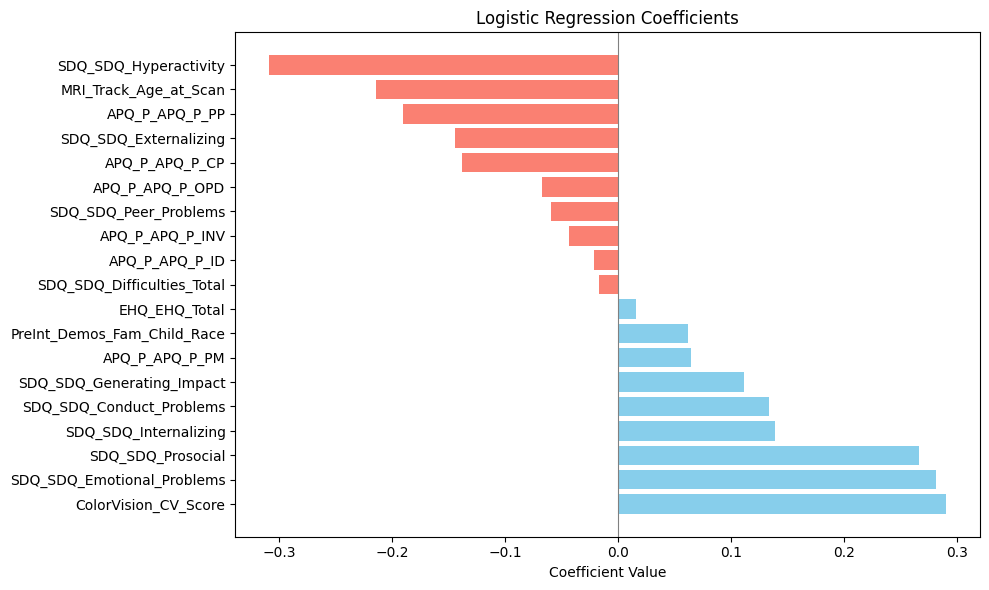

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the coefficients
coefficients = {
    "EHQ_EHQ_Total": 0.0158,
    "ColorVision_CV_Score": 0.2900,
    "APQ_P_APQ_P_CP": -0.1380,
    "APQ_P_APQ_P_ID": -0.0212,
    "APQ_P_APQ_P_INV": -0.0437,
    "APQ_P_APQ_P_OPD": -0.0676,
    "APQ_P_APQ_P_PM": 0.0642,
    "APQ_P_APQ_P_PP": -0.1903,
    "SDQ_SDQ_Conduct_Problems": 0.1329,
    "SDQ_SDQ_Difficulties_Total": -0.0173,
    "SDQ_SDQ_Emotional_Problems": 0.2814,
    "SDQ_SDQ_Externalizing": -0.1447,
    "SDQ_SDQ_Generating_Impact": 0.1109,
    "SDQ_SDQ_Hyperactivity": -0.3088,
    "SDQ_SDQ_Internalizing": 0.1382,
    "SDQ_SDQ_Peer_Problems": -0.0596,
    "SDQ_SDQ_Prosocial": 0.2661,
    "MRI_Track_Age_at_Scan": -0.2147,
    "PreInt_Demos_Fam_Child_Race": 0.0617
}

# Create a DataFrame for easy sorting and plotting
df = pd.DataFrame(list(coefficients.items()), columns=["Feature", "Coefficient"])
df = df.sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df["Feature"], df["Coefficient"], color=(df["Coefficient"] > 0).map({True: "skyblue", False: "salmon"}))
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()


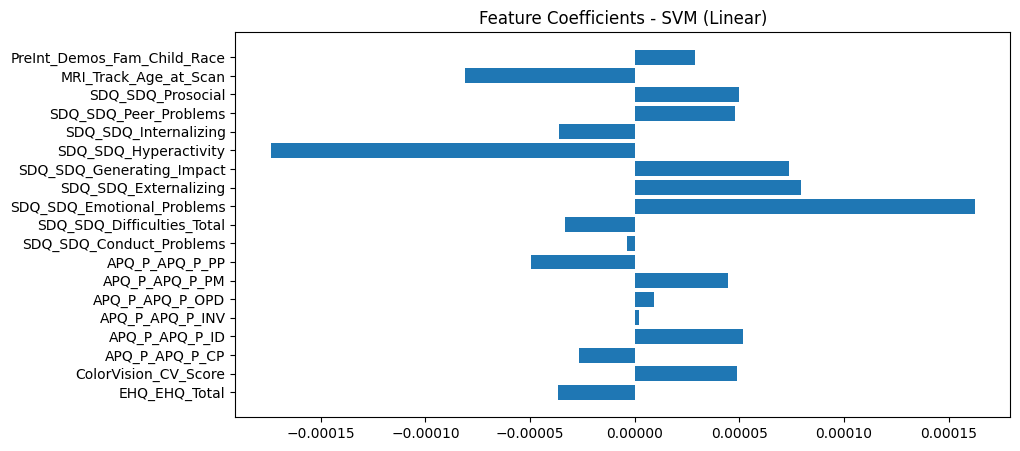

EHQ_EHQ_Total: -0.0000
ColorVision_CV_Score: 0.0000
APQ_P_APQ_P_CP: -0.0000
APQ_P_APQ_P_ID: 0.0001
APQ_P_APQ_P_INV: 0.0000
APQ_P_APQ_P_OPD: 0.0000
APQ_P_APQ_P_PM: 0.0000
APQ_P_APQ_P_PP: -0.0000
SDQ_SDQ_Conduct_Problems: -0.0000
SDQ_SDQ_Difficulties_Total: -0.0000
SDQ_SDQ_Emotional_Problems: 0.0002
SDQ_SDQ_Externalizing: 0.0001
SDQ_SDQ_Generating_Impact: 0.0001
SDQ_SDQ_Hyperactivity: -0.0002
SDQ_SDQ_Internalizing: -0.0000
SDQ_SDQ_Peer_Problems: 0.0000
SDQ_SDQ_Prosocial: 0.0000
MRI_Track_Age_at_Scan: -0.0001
PreInt_Demos_Fam_Child_Race: 0.0000


In [ ]:
# Coefficients for the Linear SVM model
svm_linear_model = models["SVM (Linear)"]
coefficients = svm_linear_model.coef_[0]

# Visualizing the coefficients for interpretation
plt.figure(figsize=(10, 5))
plt.barh(features_adhd, coefficients)
plt.title("Feature Coefficients - SVM (Linear)")
plt.show()

# Printing the coefficients for further analysis
for feature, coef in zip(features_adhd, coefficients):
    print(f"{feature}: {coef:.4f}")


In [64]:
# Coefficients for the Linear SVM model
svm_linear_model = models["SVM (Linear)"]
feature_coefficients = svm_linear_model.coef_[0]

# Print feature name and coefficient
for feature, coeff in zip(features_adhd, feature_coefficients):
    print(f"{feature}: {coeff:.4f}")



EHQ_EHQ_Total: -0.0000
ColorVision_CV_Score: 0.0000
APQ_P_APQ_P_CP: -0.0000
APQ_P_APQ_P_ID: 0.0001
APQ_P_APQ_P_INV: 0.0000
APQ_P_APQ_P_OPD: 0.0000
APQ_P_APQ_P_PM: 0.0000
APQ_P_APQ_P_PP: -0.0000
SDQ_SDQ_Conduct_Problems: -0.0000
SDQ_SDQ_Difficulties_Total: -0.0000
SDQ_SDQ_Emotional_Problems: 0.0002
SDQ_SDQ_Externalizing: 0.0001
SDQ_SDQ_Generating_Impact: 0.0001
SDQ_SDQ_Hyperactivity: -0.0002
SDQ_SDQ_Internalizing: -0.0000
SDQ_SDQ_Peer_Problems: 0.0000
SDQ_SDQ_Prosocial: 0.0000
MRI_Track_Age_at_Scan: -0.0001
PreInt_Demos_Fam_Child_Race: 0.0000


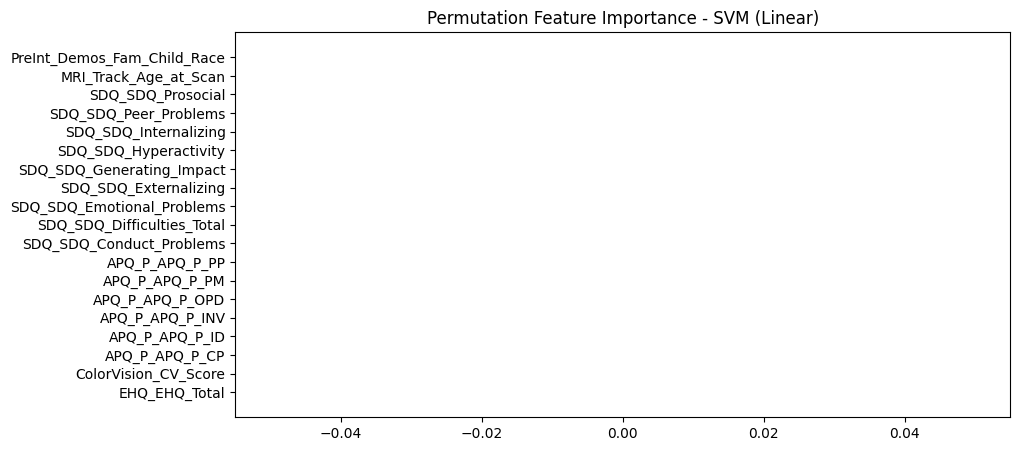

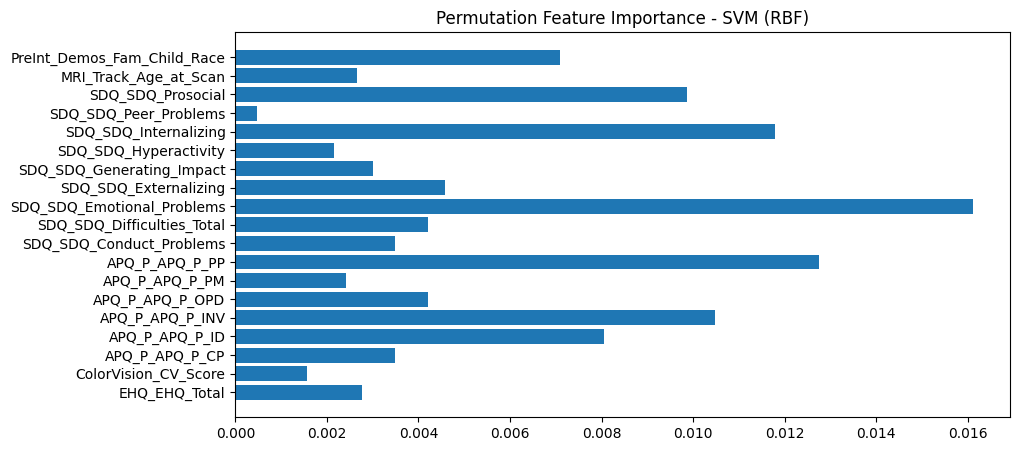

In [55]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# SVM Linear Model Permutation Importance
svm_linear_model = models["SVM (Linear)"]
perm_importance_linear = permutation_importance(svm_linear_model, X, y, n_repeats=10, random_state=SEED)

# SVM RBF Model Permutation Importance
svm_rbf_model = models["SVM (RBF)"]
perm_importance_rbf = permutation_importance(svm_rbf_model, X, y, n_repeats=10, random_state=SEED)

# Visualizing Permutation Importance for Linear SVM
plt.figure(figsize=(10, 5))
plt.barh(features_adhd, perm_importance_linear.importances_mean)
plt.title("Permutation Feature Importance - SVM (Linear)")
plt.show()

# Visualizing Permutation Importance for RBF SVM
plt.figure(figsize=(10, 5))
plt.barh(features_adhd, perm_importance_rbf.importances_mean)
plt.title("Permutation Feature Importance - SVM (RBF)")
plt.show()


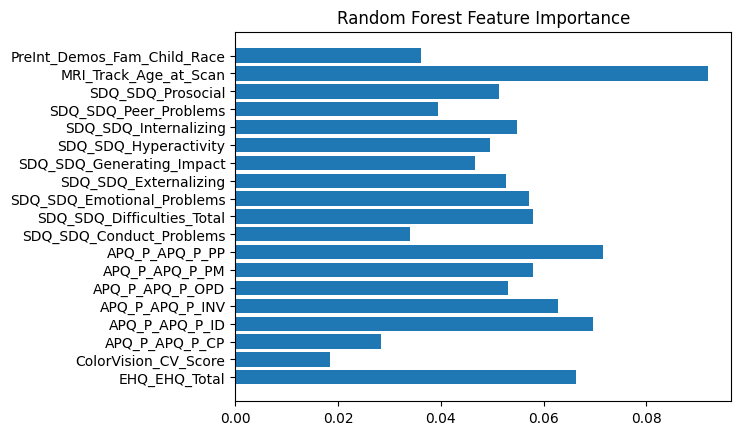

In [50]:
import matplotlib.pyplot as plt

# Random Forest Feature Importance
if hasattr(models["Random Forest"], "feature_importances_"):
    rf_importance = models["Random Forest"].feature_importances_
    plt.barh(features_adhd, rf_importance)
    plt.title("Random Forest Feature Importance")
    plt.show()

### Feature Engineering

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from itertools import combinations

def automatic_interactions(X, y, top_n=5):
    base_model = LogisticRegression(max_iter=1000)
    base_score = cross_val_score(base_model, X, y, cv=5, scoring='accuracy').mean()
    print(f"Base Logistic Regression Score: {base_score:.4f}")

    best_interactions = []
    feature_names = X.columns

    for (f1, f2) in combinations(feature_names, 2):
        # Create interaction feature
        interaction = X[f1] * X[f2]
        interaction_name = f"{f1}_x_{f2}"
        
        X_temp = X.copy()
        X_temp[interaction_name] = interaction
        
        # Train logistic regression and cross-validate
        score = cross_val_score(base_model, X_temp, y, cv=5, scoring='accuracy').mean()

        if score > base_score:
            print(f"Adding interaction: {interaction_name} improved score to {score:.4f}")
            best_interactions.append((interaction_name, score, f1, f2))

    # Sort and keep top_n best interactions
    best_interactions = sorted(best_interactions, key=lambda x: x[1], reverse=True)[:top_n]

    print("\nTop Interactions Found:")
    for interaction_name, score, f1, f2 in best_interactions:
        print(f"{interaction_name}: {score:.4f}")

    return best_interactions


In [66]:
# Assume your dataset:
# X = your scaled features (Pandas DataFrame)
# y = your target variable (0 = male, 1 = female)

best_interactions = automatic_interactions(X, y)

# Then create those top interaction features manually
for _, _, f1, f2 in best_interactions:
    X[f"{f1}_x_{f2}"] = X[f1] * X[f2]


Base Logistic Regression Score: 0.7112
Adding interaction: EHQ_EHQ_Total_x_ColorVision_CV_Score improved score to 0.7112
Adding interaction: EHQ_EHQ_Total_x_APQ_P_APQ_P_PP improved score to 0.7112
Adding interaction: EHQ_EHQ_Total_x_SDQ_SDQ_Conduct_Problems improved score to 0.7112
Adding interaction: EHQ_EHQ_Total_x_SDQ_SDQ_Hyperactivity improved score to 0.7136
Adding interaction: EHQ_EHQ_Total_x_SDQ_SDQ_Peer_Problems improved score to 0.7160
Adding interaction: EHQ_EHQ_Total_x_PreInt_Demos_Fam_Child_Race improved score to 0.7112
Adding interaction: ColorVision_CV_Score_x_APQ_P_APQ_P_ID improved score to 0.7112
Adding interaction: ColorVision_CV_Score_x_APQ_P_APQ_P_OPD improved score to 0.7112
Adding interaction: APQ_P_APQ_P_CP_x_APQ_P_APQ_P_ID improved score to 0.7136
Adding interaction: APQ_P_APQ_P_CP_x_APQ_P_APQ_P_OPD improved score to 0.7124
Adding interaction: APQ_P_APQ_P_CP_x_APQ_P_APQ_P_PM improved score to 0.7112
Adding interaction: APQ_P_APQ_P_CP_x_SDQ_SDQ_Emotional_Problems